# Protocolo: Codificación Superdensa (Superdense Coding)

## Descripción general
La **codificación superdensa** (superdense coding) es un protocolo cuántico que permite enviar **dos bits clásicos** utilizando **un único qubit**, siempre que el emisor (Alice) y el receptor (Bob) compartan previamente un par entrelazado (un estado de Bell).

### Recursos utilizados
- 2 qubits (uno para Alice y otro para Bob)
- 2 bits clásicos para el resultado final
- Entrelazamiento compartido (estado de Bell |Φ⁺⟩ = (|00⟩ + |11⟩)/√2)

### Idea principal
Alice codifica dos bits clásicos aplicando puertas cuánticas a su qubit del par entrelazado. Luego, envía **su qubit** a Bob, quien realiza una medición conjunta que le permite recuperar los dos bits originales.  

Así, el envío de **1 qubit + 1 par entrelazado** equivale a la transmisión de **2 bits clásicos**.

In [4]:
# Importaciones necesarias y conexión opcional a IBM Quantum 
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import Aer
from qiskit_ibm_runtime import Sampler

# Cargar credenciales (este paso es opcional, se puede simular)
try:
    service = QiskitRuntimeService()  # usa cuenta previamente guardada
    backend = service.backend("ibm_brisbane") #Utilizamos Brisbane, pero se puede utilizar ibm_torini
    print("Conexión con IBM Quantum Platform exitoso")
except Exception:
    backend = Aer.get_backend("aer_simulator")
    print("Utilizando el simulador de AER")

Conexión con IBM Quantum Platform exitoso


## Procedimiento

El protocolo consta de **tres etapas** principales:

1. **Preparación del estado entrelazado (Bell pair):**  
   - Bob crea el estado |Φ⁺⟩ = (|00⟩ + |11⟩)/√2 aplicando una puerta `H` y luego una `CX`.

2. **Codificación por Alice:**  
   - Alice aplica una combinación de puertas `I`, `X`, `Z`, o `XZ` según los dos bits clásicos que quiere transmitir.

3. **Decodificación por Bob:**  
   - Bob aplica operaciones inversas (`CX` y `H`) y mide ambos qubits para recuperar los bits originales.


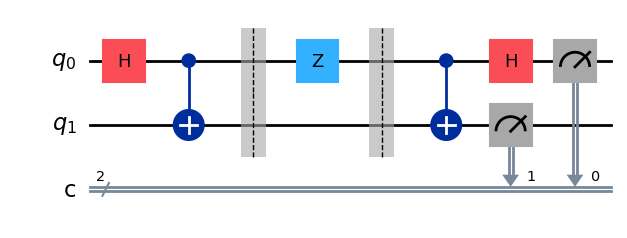

In [6]:
# Creación del circuito base
qc = QuantumCircuit(2, 2)  # 2 qubits (Alice: q0, Bob: q1), 2 bits clásicos

# 1) Creación del estado de Bell compartido
qc.h(0)          # H sobre el qubit de Alice
qc.cx(0, 1)      # CNOT entre Alice y Bob
qc.barrier()

# 2) Codificación de dos bits por Alice (por ejemplo: 10 -> aplica Z)
message = "10"
if message == "00":
    pass
elif message == "01":
    qc.x(0)
elif message == "10":
    qc.z(0)
elif message == "11":
    qc.z(0)
    qc.x(0)
qc.barrier()

# 3) Decodificación por Bob
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])
qc.draw("mpl")


### Explicación del circuito
- **Qubits:**  
  `q0` (Alice) y `q1` (Bob).  
  Inicialmente ambos en |0⟩.

- **Entrelazamiento:**  
  La secuencia `H → CX` crea el estado de Bell |Φ⁺⟩ = (|00⟩ + |11⟩)/√2.

- **Codificación:**  
  Alice aplica una de las operaciones siguientes según los bits clásicos que desea enviar:

  | Bits clásicos | Operación |
  |:--------------:|:----------|
  | 00 | I |
  | 01 | X |
  | 10 | Z |
  | 11 | XZ (o iY) |

- **Decodificación:**  
  Bob aplica `CX` y `H` en su qubit para transformar los estados de Bell en la base computacional.  
  Finalmente mide ambos qubits → obtiene los **dos bits originales**.


Transpilando el circuito para el backend...
Transpilación completada.
Enviando trabajo al Sampler...
Trabajo completado.
Mensaje enviado: 10


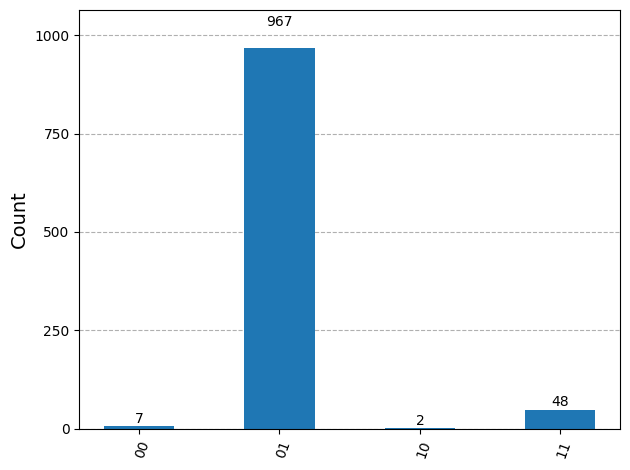

In [11]:
# Ejecución y transpilación del circuito
print("Transpilando el circuito para el backend...")
tqc = transpile(qc, backend=backend)
print("Transpilación completada.")

sampler = Sampler(mode=backend)
print("Enviando trabajo al Sampler...")

job = sampler.run([tqc], shots=1024) 
result = job.result()
print("Trabajo completado.")

pub_result = result[0]
counts = pub_result.data.c.get_counts()

print(f"Mensaje enviado: {message}")
plot_histogram(counts)


### Interpretación de resultados
- El histograma mostrará una única salida dominante, correspondiente al **mensaje que Alice codificó**.
- Por ejemplo, si Alice codificó “10”, el resultado dominante será “10”.
- Esto demuestra que Bob puede recuperar **dos bits de información clásica** enviando **un solo qubit cuántico** (gracias al entrelazamiento compartido).


In [12]:
# (Opcional) Visualización del estado en la esfera de Bloch
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Únicamente se permite la visualización si el backend es un simulador.
# NO es el caso de esta notebook.
if "simulator" in backend.name:  
    # Estado después de la codificación
    qc_no_measure = qc.remove_final_measurements(inplace=False)
    state = Statevector.from_instruction(qc_no_measure)
    display(plot_bloch_multivector(state))
else:
    print(f"No se puede generar el Statevector: El backend '{backend.name}' no es un simulador.")

No se puede generar el Statevector: El backend 'ibm_brisbane' no es un simulador.


## Conclusión

La **codificación superdensa** ilustra cómo el entrelazamiento permite optimizar la transmisión de información clásica.  
Usando un único qubit (más un estado de Bell compartido), Alice puede enviar 2 bits clásicos a Bob.  
Este protocolo y la **teleportación cuántica** son, en efecto, *dos caras de una misma moneda*:
- En la teleportación, se transmite **un estado cuántico** usando **bits clásicos** y entrelazamiento.  
- En la codificación superdensa, se transmiten **bits clásicos** usando **un qubit cuántico** y entrelazamiento.
